In [10]:
import pandas as pd
import folium
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import os
import requests, io


In [11]:
%matplotlib inline

In [12]:
CLIENT_ID = os.environ.get('FOURSQUARE_ID')
CLIENT_SECRET = os.environ.get('FOURSQUARE_SECRET')

VERSION = '20180605' # Foursquare API version
LIMIT = 100

In [13]:
postcode_url = 'https://www.doogal.co.uk/UKPostcodesCSV.ashx?area=London'
london_codes_all = pd.read_csv(postcode_url)

In [14]:
london_codes_all.head(5)

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,County,District,Ward,...,User Type,Last updated,Nearest station,Distance to station,Postcode area,Postcode district,Police force,Water company,Plus Code,Average Income
0,BR1 1AA,Yes,51.401546,0.015415,540291,168873,TQ402688,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley South,0.218257,BR,BR1,Metropolitan Police,Thames Water,9F32C228+J5,63100
1,BR1 1AB,Yes,51.406333,0.015208,540262,169405,TQ402694,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley North,0.253666,BR,BR1,Metropolitan Police,Thames Water,9F32C248+G3,56100
2,BR1 1AD,No,51.400057,0.016715,540386,168710,TQ403687,Greater London,Bromley,Bromley Town,...,1,2020-02-19,Bromley South,0.044559,BR,BR1,Metropolitan Police,NaN,9F32C228+2M,63100
3,BR1 1AE,Yes,51.404543,0.014195,540197,169204,TQ401692,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley North,0.462939,BR,BR1,Metropolitan Police,Thames Water,9F32C237+RM,63100
4,BR1 1AF,Yes,51.401392,0.014948,540259,168855,TQ402688,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley South,0.227664,BR,BR1,Metropolitan Police,Thames Water,9F32C227+HX,63100


In [15]:
london_relevant_columns = london_codes_all[['District','Ward', 'Constituency', 'Postcode district', 'Postcode', 'Latitude', 'Longitude']]

In [16]:
london_relevant_columns.head()

,District,Ward,Constituency,Postcode district,Postcode,Latitude,Longitude
0,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AA,51.401546,0.015415
1,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AB,51.406333,0.015208
2,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AD,51.400057,0.016715
3,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AE,51.404543,0.014195
4,Bromley,Bromley Town,Bromley and Chislehurst,BR1,BR1 1AF,51.401392,0.014948


In [17]:
london_relevant_columns.shape

(321834, 7)

From the table we can see that there are a number of different ways to group neighbourhoods in London; District, ward and Consituency. In addition we can see that there is an additonal level of granularity we can see in specific postcodes. We will visualise each of these grouping layers using folium maps to understand the merits of each method

In [20]:
# Central coordinates for London obtained from google maps
latitude = 51.5074
longitude = -0.1278

In [246]:
def create_map(frame, layer):
# create map using latitude and longitude values
    map_folium = folium.Map(location=[latitude, longitude], zoom_start=10)

    # add markers to map
    for lat, lng, layer in zip(frame['Latitude'], frame['Longitude'], frame[layer]):
        label = '{}'.format(layer)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_folium)  

    return map_folium

In order to obtain a centroid location for the different layers of geographical groupings, I have used the group by method and will take the mean of the components coordinates that form a geographical layer.

In [247]:
consituencies = london_relevant_columns.groupby('Constituency').agg('mean').reset_index()
consituencies.head()

,Constituency,Latitude,Longitude
0,Barking,51.540223,0.108926
1,Battersea,51.467693,-0.156828
2,Beckenham,51.392635,-0.010579
3,Bermondsey and Old Southwark,51.495689,-0.079441
4,Bethnal Green and Bow,51.524791,-0.054384


In [248]:
create_map(consituencies,'Constituency')

In [249]:
Borough = london_relevant_columns.groupby('District').agg('mean').reset_index()
create_map(Borough,'District')

In [253]:
districts = london_relevant_columns.groupby('Postcode district').agg('mean').reset_index()
create_map(districts,'Postcode district')

The map above shows us that using postocode districts results in large geographical cluster of points in central London. these points much closer to each other than the points in the outer areas of the city. As a result any analysis on geographical features may result in a skewed data set for these points are they will be very geographically similar. 

In order to correct this, we can either use a higher layer geographical aggregation or we will have to clean the data in some way to reduce these clusters points. For the initial analysis I will clean the data at this level, due to additional merits of using the granular data. However, this can be ammended if the results are affected in any way.

In [23]:
# Residential london only
districts = districts[
    (districts['Postcode district'].str[0]=='E') 
    | (districts['Postcode district'].str[0]=='N')
    | (districts['Postcode district'].str[0]=='S')
    | (districts['Postcode district'].str[0]=='W')
]
districts = districts[
    (districts['Postcode district'].str[0:2]!='EN')
    & (districts['Postcode district'].str[0:2]!='SM')
    & (districts['Postcode district'].str[0:2]!='WD')
    & (districts['Postcode district'].str[0:2]!='WC')
    & (districts['Postcode district'].str[0:2]!='W1')
    & (districts['Postcode district'].str[0:2]!='EC')
    & (districts['Postcode district'].str[0:3]!='SW1')
]

## Analyse data on UK house transactions

In [280]:
prices_2020_url = 'http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2020.csv'
prices_2020 = pd.read_csv(prices_2020_url, header=None)
prices_2020.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,{9FF0D969-FE3D-11ED-E053-6C04A8C06383},309000,2020-02-07 00:00,NR29 4BQ,D,N,F,HILL COTTAGE,NaN,OLD CHAPEL ROAD,WINTERTON ON SEA,GREAT YARMOUTH,GREAT YARMOUTH,NORFOLK,A,A
1,{9FF0D969-FE3E-11ED-E053-6C04A8C06383},343250,2020-01-17 00:00,NR6 5QD,S,N,F,37,NaN,WOOD VIEW ROAD,HELLESDON,NORWICH,BROADLAND,NORFOLK,A,A


In [281]:
# prices_2020.rename(columns={
#     0:'id',
#     1:'price',
#     2:'transaction_date',
#     3:'postcode',
    
# })

In [401]:
london_prices = prices_2020[prices_2020[13]=='GREATER LONDON']
london_prices.shape

(12009, 16)

In [402]:
transactions_geo = london_prices.merge(london_relevant_columns, how='left', left_on=3, right_on='Postcode')
transactions_geo.shape

(12009, 23)

In [403]:
transactions_geo[transactions_geo['Postcode'].notnull()].shape

(11914, 23)

In [404]:
transactions_geo.head(3)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,District,Ward,Constituency,Postcode district,Postcode,Latitude,Longitude
0,{A2479555-988B-74C7-E053-6B04A8C0887D},435000,2020-02-21 00:00,CR4 3BZ,T,N,F,49,NaN,HOMEFIELD GARDENS,...,GREATER LONDON,A,A,Merton,Cricket Green,Mitcham and Morden,CR4,CR4 3BZ,51.408905,-0.182207
1,{A2479555-988D-74C7-E053-6B04A8C0887D},910000,2020-02-19 00:00,KT1 3PL,S,N,F,5,NaN,HOMERSHAM ROAD,...,GREATER LONDON,A,A,Kingston upon Thames,Norbiton,Kingston and Surbiton,KT1,KT1 3PL,51.411178,-0.282775
2,{A2479555-988E-74C7-E053-6B04A8C0887D},405000,2020-01-31 00:00,CR4 1LY,T,N,F,14,NaN,ELM GARDENS,...,GREATER LONDON,A,A,Merton,Pollards Hill,Mitcham and Morden,CR4,CR4 1LY,51.398912,-0.135119


Analysing price distribution across the 162 london postcodes, including premium central london postcodes

In [405]:
def group_transactions(frame, layer):
    avg_prices = frame[[layer,1]].groupby(layer).mean().reset_index()
    avg_prices[1] = avg_prices[1].astype(int)
    avg_prices.rename(columns={1:'avg_price'}, inplace=True)
    return avg_prices

(array([22., 44., 29., 37., 18., 15., 16.,  9.,  5.,  4.,  4.,  3.,  3.,
         7.,  2.,  3.,  3.,  1.,  2.,  2.,  0.,  1.,  1.,  2.,  2.,  0.,
         2.,  0.,  0.,  2.,  3.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([ 312171.        ,  386004.67346939,  459838.34693878,
         533672.02040816,  607505.69387755,  681339.36734694,
         755173.04081633,  829006.71428571,  902840.3877551 ,
         976674.06122449, 1050507.73469388, 1124341.40816327,
        1198175.08163265, 1272008.75510204, 1345842.42857143,
        1419676.10204082, 1493509.7755102 , 1567343.44897959,
        1641177.12244898, 1715010.79591837, 1788844.46938776,
        1862678.14285714, 1936511.81632653, 2010345.48979592,
        2084179.16326531, 2158012.83673469, 2231846.51020408,
        2305680.18367347, 2379513.85714286, 2453347.53061224,
        2527181.20408163, 2601014.87755102, 2674848.55102041,
        2748682.2244898 , 2822515.89795

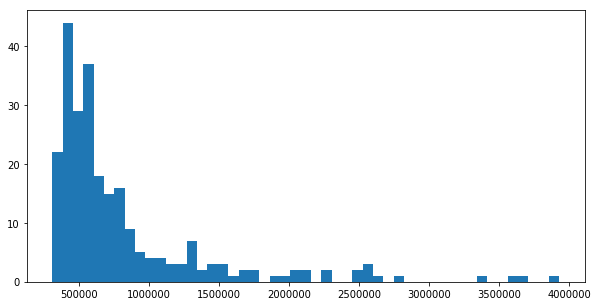

In [408]:
postcode_prices = group_transactions(transactions_geo, 'Postcode district')
bins = np.linspace(y.min(), y.max(), 50)
plt.figure(figsize=(10,5))
plt.hist(postcode_prices['avg_price'], bins=bins)

(array([14., 23., 15.,  6.,  5.,  2.,  0.,  1.,  3.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 312171.  ,  462914.75,  613658.5 ,  764402.25,  915146.  ,
        1065889.75, 1216633.5 , 1367377.25, 1518121.  , 1668864.75,
        1819608.5 , 1970352.25, 2121096.  , 2271839.75, 2422583.5 ,
        2573327.25, 2724071.  , 2874814.75, 3025558.5 , 3176302.25,
        3327046.  , 3477789.75, 3628533.5 , 3779277.25, 3930021.  ]),
 <a list of 24 Patch objects>)

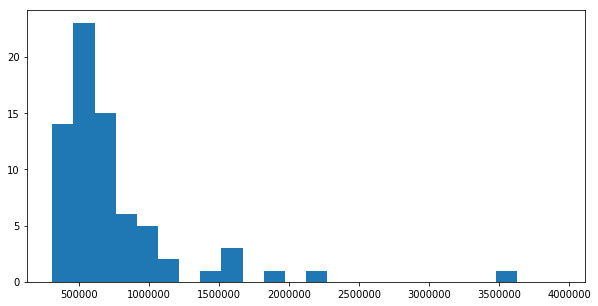

In [409]:
constituency_prices = group_transactions(transactions_geo, 'Constituency')
bins = np.linspace(y.min(), y.max(), 25)
plt.figure(figsize=(10,5))
plt.hist(constituency_prices['avg_price'], bins=bins)

(array([ 2., 13.,  8.,  2.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 312171.  ,  462914.75,  613658.5 ,  764402.25,  915146.  ,
        1065889.75, 1216633.5 , 1367377.25, 1518121.  , 1668864.75,
        1819608.5 , 1970352.25, 2121096.  , 2271839.75, 2422583.5 ,
        2573327.25, 2724071.  , 2874814.75, 3025558.5 , 3176302.25,
        3327046.  , 3477789.75, 3628533.5 , 3779277.25, 3930021.  ]),
 <a list of 24 Patch objects>)

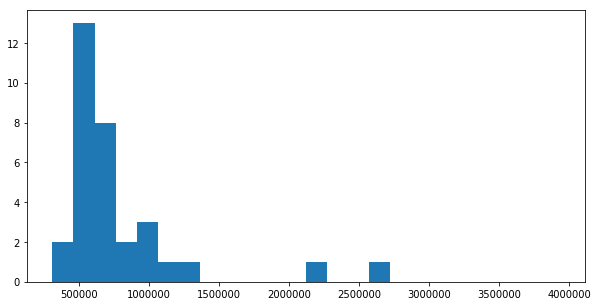

In [410]:
borough_prices = group_transactions(transactions_geo, 'District')
bins = np.linspace(y.min(), y.max(), 25)
plt.figure(figsize=(10,5))
plt.hist(borough_prices['avg_price'], bins=bins)

### Use foursquare to get local venues

In [26]:
CLIENT_ID = os.environ.get('FOURSQUARE_ID')
CLIENT_SECRET = os.environ.get('FOURSQUARE_SECRET')

VERSION = '20180605' # Foursquare API version
LIMIT = 500

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
london_venues_raw = getNearbyVenues(names=districts['Postcode district'],
                                   latitudes=districts['Latitude'],
                                   longitudes=districts['Longitude']
                                  )

E1
E10
E11
E12
E13
E14
E15
E16
E17
E18
E1W
E2
E20
E3
E4
E5
E6
E7
E77
E8
E9
E98
N1
N10
N11
N12
N13
N14
N15
N16
N17
N18
N19
N1C
N1P
N2
N20
N21
N22
N3
N4
N5
N6
N7
N8
N81
N9
NW1
NW10
NW11
NW1W
NW2
NW26
NW3
NW4
NW5
NW6
NW7
NW8
NW9
SE1
SE10
SE11
SE12
SE13
SE14
SE15
SE16
SE17
SE18
SE19
SE1P
SE2
SE20
SE21
SE22
SE23
SE24
SE25
SE26
SE27
SE28
SE3
SE4
SE5
SE6
SE7
SE8
SE9
SE99
SW2
SW20
SW3
SW4
SW5
SW6
SW7
SW8
SW9
SW95
SW99
W2
W3
W4
W5
W6
W7
W8
W9


In [309]:
# consituencies
consitutency_venues_raw = getNearbyVenues(names=consituencies['Constituency'],
                                   latitudes=consituencies['Latitude'],
                                   longitudes=consituencies['Longitude']
                                  )

Barking
Battersea
Beckenham
Bermondsey and Old Southwark
Bethnal Green and Bow
Bexleyheath and Crayford
Brent Central
Brent North
Brentford and Isleworth
Bromley and Chislehurst
Camberwell and Peckham
Carshalton and Wallington
Chelsea and Fulham
Chingford and Woodford Green
Chipping Barnet
Cities of London and Westminster
Croydon Central
Croydon North
Croydon South
Dagenham and Rainham
Dulwich and West Norwood
Ealing Central and Acton
Ealing North
Ealing, Southall
East Ham
Edmonton
Eltham
Enfield North
Enfield, Southgate
Erith and Thamesmead
Feltham and Heston
Finchley and Golders Green
Greenwich and Woolwich
Hackney North and Stoke Newington
Hackney South and Shoreditch
Hammersmith
Hampstead and Kilburn
Harrow East
Harrow West
Hayes and Harlington
Hendon
Holborn and St Pancras
Hornchurch and Upminster
Hornsey and Wood Green
Ilford North
Ilford South
Islington North
Islington South and Finsbury
Kensington
Kingston and Surbiton
Lewisham East
Lewisham West and Penge
Lewisham, Deptford
Le

In [29]:
london_venues1 = london_venues_raw.copy()
london_venues1.shape

(3294, 7)

In [72]:
london_venues1[london_venues1['Neighborhood']=='E1'].head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,E1,51.516257,-0.060423,Lahore One,51.514725,-0.059399,Indian Restaurant
1,E1,51.516257,-0.060423,Lahore Kebab House,51.514483,-0.062912,Kebab Restaurant
2,E1,51.516257,-0.060423,New Road Hotel,51.517575,-0.062658,Hotel
3,E1,51.516257,-0.060423,Needoo Grill,51.517070,-0.062379,Indian Restaurant
4,E1,51.516257,-0.060423,Mouse Tail Coffee Stories,51.519471,-0.058573,Coffee Shop


In [31]:
london2 = london_venues1[
    (london_venues1['Neighborhood'].str[0]=='E') 
    | (london_venues1['Neighborhood'].str[0]=='N')
    | (london_venues1['Neighborhood'].str[0]=='S')
    | (london_venues1['Neighborhood'].str[0]=='W')
]
london_filter = london2[
    (london_venues1['Neighborhood'].str[0:2]!='EN')
    & (london_venues1['Neighborhood'].str[0:2]!='SM')
    & (london_venues1['Neighborhood'].str[0:2]!='WD')
    & (london_venues1['Neighborhood'].str[0:2]!='WC')
    & (london_venues1['Neighborhood'].str[0:2]!='EC')
]

In [32]:
london_filter['Neighborhood'].unique()

array(['E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17',
       'E18', 'E1W', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E77',
       'E8', 'E9', 'E98', 'N1', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15',
       'N16', 'N17', 'N18', 'N19', 'N1C', 'N1P', 'N2', 'N20', 'N21',
       'N22', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N81', 'N9', 'NW1',
       'NW10', 'NW11', 'NW1W', 'NW2', 'NW26', 'NW3', 'NW4', 'NW5', 'NW6',
       'NW7', 'NW8', 'NW9', 'SE1', 'SE10', 'SE11', 'SE12', 'SE13', 'SE14',
       'SE15', 'SE16', 'SE17', 'SE18', 'SE19', 'SE1P', 'SE2', 'SE20',
       'SE21', 'SE22', 'SE23', 'SE24', 'SE25', 'SE26', 'SE27', 'SE28',
       'SE3', 'SE4', 'SE5', 'SE6', 'SE7', 'SE8', 'SE9', 'SE99', 'SW2',
       'SW20', 'SW3', 'SW4', 'SW5', 'SW6', 'SW7', 'SW8', 'SW9', 'SW95',
       'SW99', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9'],
      dtype=object)

In [33]:
london_venues = london_filter.copy()

In [34]:
# london_venues[london_venues['Neighborhood']=='BR2']

In [35]:
london_venues['Venue Category'].value_counts().head()

Pub                   263
Café                  201
Coffee Shop           198
Grocery Store         130
Italian Restaurant     94
Name: Venue Category, dtype: int64

In [36]:
london_venues.Venue.value_counts().head()

Costa Coffee         43
Subway               28
Tesco Express        25
Sainsbury's Local    24
Co-op Food           22
Name: Venue, dtype: int64

In [37]:
# london_venues['Venue Category'] = london_venues['Venue']

### one hot encoding

In [320]:
def pre_processing(frame):
    london_one_hot = pd.get_dummies(frame[['Venue Category']], prefix="", prefix_sep="")
    london_one_hot['layer'] = frame['Neighborhood']
    london_grouped_category = london_one_hot.groupby('layer').mean().reset_index()
    return london_grouped_category

In [326]:
london_grouped = pre_processing(london_venues)
london_grouped.shape

(109, 275)

In [323]:
london_grouped.head()

,layer,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Game Store,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,E1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.025641
1,E10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,E11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.025641,0.025641,0.0,0.0,0.025641,0.0,0.0,0.0,0.000000
3,E12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,E13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [364]:
def get_top_venues(frame):
    num_top_venues = 10

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['layer']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    top_venues = pd.DataFrame(columns=columns)
    top_venues['layer'] = frame['layer']

    for ind in np.arange(frame.shape[0]):
        top_venues.iloc[ind, 1:] = return_most_common_venues(frame.iloc[ind, :], num_top_venues)
        
    return top_venues

In [331]:
neighborhoods_venues_sorted = get_top_venues(london_grouped)
neighborhoods_venues_sorted.shape

(109, 11)

In [330]:
neighborhoods_venues_sorted.head()

,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,E1,Hotel,Indian Restaurant,Grocery Store,Coffee Shop,Pub,Sandwich Place,Gym / Fitness Center,North Indian Restaurant,Outdoor Sculpture,Recreation Center
1,E10,Park,Cricket Ground,Coffee Shop,Farm,Train Station,Asian Restaurant,Indian Restaurant,Convenience Store,Hotel,Fish Market
2,E11,Pub,Café,Grocery Store,Fast Food Restaurant,Pizza Place,Coffee Shop,Pharmacy,Thrift / Vintage Store,Mediterranean Restaurant,Burger Joint
3,E12,Train Station,Indian Restaurant,Restaurant,Gym / Fitness Center,Yoga Studio,Falafel Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop
4,E13,Pub,Café,Bus Station,Gym,Fast Food Restaurant,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market


In [359]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split
# from sklearn import metrics

In [335]:

# from scipy.spatial.distance import cdist

# distortions = []
# K = range(1,20)
# for k in K:
#     kmeanModel = KMeans(n_clusters=k, random_state=0).fit(london_grouped_clustering)
#     #kmeanModel.fit(istanbul_grouped_clustering)
#     distortions.append(sum(np.min(cdist(london_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / london_grouped_clustering.shape[0])

# #There are different metric distance function for spatial distance. 
# #I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [355]:
def kmeans_plot(frame,k):
    grouped_clustering = frame.drop('layer', 1)
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(grouped_clustering)
    # plot
    return plt.hist(kmeans.labels_, bins=k)

(array([ 2., 54.,  1.,  1.,  1., 45.,  1.,  2.,  1.,  1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

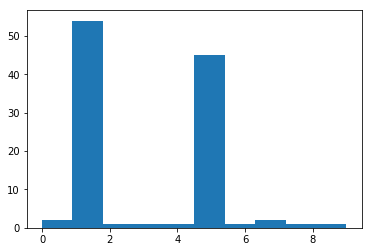

In [356]:
kmeans_plot(london_grouped, 10)

(array([30.,  1., 75.,  1.,  2.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <a list of 5 Patch objects>)

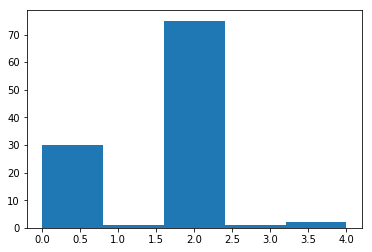

In [431]:
kmeans_plot(london_grouped, 5)

(array([108.,   1.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

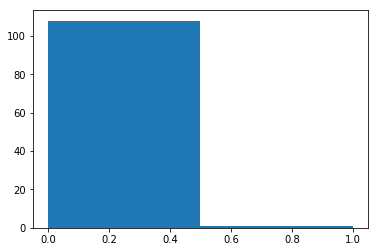

In [358]:
kmeans_plot(london_grouped, 2)

In [317]:
len(kmeans.labels_)

109

In [ ]:
london_data = districts.copy()

In [ ]:
labels = kmeans.labels_
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels)

In [350]:
def rejoin_clusters(frame1, frame2):
    london_data = frame1.copy()
    labels = kmeans.labels_
    london_data.columns = ['layer', 'Latitude', 'Longitude']
    frame_merged = london_data.merge(frame2, on='layer')
    return frame_merged

In [353]:
london_merged = rejoin_clusters(districts,neighborhoods_venues_sorted)

In [354]:
london_merged.head()

,layer,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,E1,51.516257,-0.060423,Hotel,Indian Restaurant,Grocery Store,Coffee Shop,Pub,Sandwich Place,Gym / Fitness Center,North Indian Restaurant,Outdoor Sculpture,Recreation Center
1,E10,51.568702,-0.012773,Park,Cricket Ground,Coffee Shop,Farm,Train Station,Asian Restaurant,Indian Restaurant,Convenience Store,Hotel,Fish Market
2,E11,51.567375,0.011668,Pub,Café,Grocery Store,Fast Food Restaurant,Pizza Place,Coffee Shop,Pharmacy,Thrift / Vintage Store,Mediterranean Restaurant,Burger Joint
3,E12,51.551033,0.050806,Train Station,Indian Restaurant,Restaurant,Gym / Fitness Center,Yoga Studio,Falafel Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop
4,E13,51.528216,0.025794,Pub,Café,Bus Station,Gym,Fast Food Restaurant,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market


### Map of london clusters

In [208]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Postcode district'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [209]:
london_merged.shape[1]

14

In [211]:
london_merged = london_merged.merge(avg_prices, how='left', on='Postcode district')
london_merged.shape

(109, 16)

In [212]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price_x,avg_price_y
0,E1,Hotel,Indian Restaurant,Grocery Store,Coffee Shop,Pub,Sandwich Place,Gym / Fitness Center,North Indian Restaurant,Outdoor Sculpture,Recreation Center,714580.0,714580.0
1,E10,Park,Cricket Ground,Coffee Shop,Farm,Train Station,Asian Restaurant,Indian Restaurant,Convenience Store,Hotel,Fish Market,436535.0,436535.0
8,E17,Grocery Store,Coffee Shop,Sandwich Place,Pizza Place,Pub,Bakery,Clothing Store,Bookstore,Café,Pharmacy,816658.0,816658.0
9,E18,Café,Grocery Store,Italian Restaurant,Chinese Restaurant,Supermarket,Bar,Coffee Shop,Pizza Place,Greek Restaurant,Fast Food Restaurant,503071.0,503071.0
10,E1W,Grocery Store,Park,Indian Restaurant,Fast Food Restaurant,Bus Stop,Event Space,Sandwich Place,Fried Chicken Joint,Bar,Kebab Restaurant,751524.0,751524.0
15,E5,Grocery Store,Pub,Gastropub,Gym / Fitness Center,Beer Bar,Business Service,Liquor Store,Cocktail Bar,Coffee Shop,Park,630896.0,630896.0
17,E7,Grocery Store,Bus Stop,Train Station,Market,Pub,Bakery,Comfort Food Restaurant,Fast Food Restaurant,Café,Chinese Restaurant,445440.0,445440.0
24,N11,Grocery Store,Electronics Store,Fish & Chips Shop,Beer Bar,Shopping Plaza,Scenic Lookout,Toy / Game Store,Hardware Store,Train Station,Furniture / Home Store,497886.0,497886.0
25,N12,Coffee Shop,Supermarket,Fast Food Restaurant,Pharmacy,Hotel,Bookstore,Clothing Store,Bar,Sushi Restaurant,Beer Store,729615.0,729615.0
31,N18,Coffee Shop,Fast Food Restaurant,Turkish Restaurant,Pizza Place,Bistro,Supermarket,Sandwich Place,Park,Grocery Store,Bakery,363683.0,363683.0


In [213]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price_x,avg_price_y
82,SE3,Lake,Fast Food Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Yoga Studio,Food Service,586347.0,586347.0


In [214]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price_x,avg_price_y
2,E11,Pub,Café,Grocery Store,Fast Food Restaurant,Pizza Place,Coffee Shop,Pharmacy,Thrift / Vintage Store,Mediterranean Restaurant,Burger Joint,622410.0,622410.0
3,E12,Train Station,Indian Restaurant,Restaurant,Gym / Fitness Center,Yoga Studio,Falafel Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,385272.0,385272.0
4,E13,Pub,Café,Bus Station,Gym,Fast Food Restaurant,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,312171.0,312171.0
5,E14,Coffee Shop,Park,Gym / Fitness Center,Italian Restaurant,Café,Burger Joint,Plaza,Hotel,Indian Restaurant,Restaurant,507683.0,507683.0
6,E15,Pub,Platform,Hotel,Coffee Shop,Sandwich Place,Fast Food Restaurant,Bus Stop,Shopping Mall,Bar,General Entertainment,427562.0,427562.0
7,E16,Hotel,Café,Chinese Restaurant,Convenience Store,Pub,Light Rail Station,Steakhouse,Grocery Store,Scenic Lookout,Coffee Shop,756068.0,756068.0
11,E2,Coffee Shop,Pub,Cocktail Bar,Café,Hotel,Italian Restaurant,Bar,Flower Shop,Gym / Fitness Center,Pizza Place,471528.0,471528.0
12,E20,Café,Clothing Store,Coffee Shop,Ice Cream Shop,Italian Restaurant,Pub,Toy / Game Store,Pizza Place,Burger Joint,Chocolate Shop,550000.0,550000.0
13,E3,Pub,Grocery Store,Hotel,Rental Car Location,Burger Joint,Locksmith,Light Rail Station,Park,Bar,Bus Stop,437487.0,437487.0
18,E77,Hotel,Coffee Shop,Pub,Indian Restaurant,Café,Cocktail Bar,Thai Restaurant,Sushi Restaurant,Bar,Pizza Place,NaN,NaN


In [215]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price_x,avg_price_y
14,E4,Pub,Yoga Studio,Fast Food Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Filipino Restaurant,423437.0,423437.0


In [216]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price_x,avg_price_y
16,E6,Grocery Store,Café,Park,Nature Preserve,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Yoga Studio,1304758.0,1304758.0
28,N15,Café,Grocery Store,Park,Hostel,Flea Market,Fish Market,Fish & Chips Shop,Film Studio,Filipino Restaurant,Fast Food Restaurant,610715.0,610715.0


In [217]:
london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price_x,avg_price_y


In [457]:
constituency_prices.head()

,Constituency,avg_price,price_band
0,Barking,309774,cheap
1,Battersea,825188,expensive
2,Beckenham,550097,mid range
3,Bermondsey and Old Southwark,1568092,expensive
4,Bethnal Green and Bow,653344,premium


In [412]:
consituencies[~consituencies['Constituency'].isin(constituency_prices['Constituency'])]['Constituency'].unique()

array([], dtype=object)

In [416]:
lower = np.percentile(constituency_prices['avg_price'],25)
median = np.percentile(constituency_prices['avg_price'],50)
upper = np.percentile(constituency_prices['avg_price'],75)
# constituency_prices['price_band'] = constituency_prices['avg_price'].apply(lambda x: 'mid range' if x<=upper else None)
constituency_prices.loc[constituency_prices['avg_price'] > upper, 'price_band'] = 'expensive' 
constituency_prices.loc[constituency_prices['avg_price'] <= upper, 'price_band'] = 'premium' 
constituency_prices.loc[constituency_prices['avg_price'] <= median, 'price_band'] = 'mid range' 
constituency_prices.loc[constituency_prices['avg_price'] <= lower, 'price_band'] = 'cheap' 

In [418]:
constituency_prices.head()

,Constituency,avg_price,price_band
0,Barking,309774,cheap
1,Battersea,825188,expensive
2,Beckenham,550097,mid range
3,Bermondsey and Old Southwark,1568092,expensive
4,Bethnal Green and Bow,653344,premium


In [434]:
constits = consitutency_venues_raw.copy()
constits.shape

(1271, 7)

In [435]:
def pre_processing_price(frame):
    london_one_hot = pd.get_dummies(frame[['price_band']], prefix="", prefix_sep="")
    london_one_hot['layer'] = frame['Constituency']
    return london_one_hot

In [436]:
constits['Venue Category'].value_counts().head()

Pub              77
Café             75
Coffee Shop      69
Grocery Store    59
Hotel            33
Name: Venue Category, dtype: int64

In [437]:
constits_grouped = pre_processing(constits)
constits_grouped.shape

(72, 223)

In [439]:
constits_grouped.shape

(72, 223)

In [420]:
price_one_hot = pre_processing_price(constituency_prices)

In [440]:
price_one_hot.shape

(73, 5)

In [463]:
price_cluster = price_one_hot.merge(constits_grouped, how='inner', on='layer')
price_cluster.shape

(72, 227)

In [464]:
constit_venues_sorted = get_top_venues(constits_grouped)
constit_venues_sorted.shape

(72, 11)

(array([18., 19., 18., 16.,  1.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <a list of 5 Patch objects>)

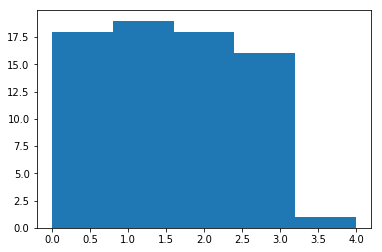

In [465]:
kmeans_plot(price_cluster,5)

In [466]:
kcluster_price = 5
price_cluster = price_cluster.drop('layer', 1)
kmeans = KMeans(n_clusters=kcluster_price, random_state=0).fit(price_cluster)

In [467]:
labels = kmeans.labels_
len(labels)
constit_venues_sorted.insert(0, 'Cluster Labels', labels)

In [468]:
constit_venues_sorted.head()

,Cluster Labels,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Barking,River,Pub,Chinese Restaurant,Grocery Store,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit
1,0,Battersea,Café,Thai Restaurant,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Yoga Studio,Burger Joint,Spa,Restaurant
2,4,Beckenham,Gym,Yoga Studio,Distillery,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit
3,0,Bermondsey and Old Southwark,Coffee Shop,Bus Stop,Pub,Italian Restaurant,Park,Middle Eastern Restaurant,Food Truck,Cocktail Bar,Pie Shop,Bike Shop
4,2,Bethnal Green and Bow,Coffee Shop,Pub,Café,Cocktail Bar,Pizza Place,Grocery Store,Park,Brewery,Beer Bar,Fast Food Restaurant


In [469]:
x = rejoin_clusters(consituencies,constit_venues_sorted)
constituency_prices.rename(columns={'Constituency':'layer'}, inplace=True)
final_df = x.merge(constituency_prices, on='layer')

In [470]:
final_df.head()

,layer,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
0,Barking,51.540223,0.108926,1,River,Pub,Chinese Restaurant,Grocery Store,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,309774,cheap
1,Battersea,51.467693,-0.156828,0,Café,Thai Restaurant,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Yoga Studio,Burger Joint,Spa,Restaurant,825188,expensive
2,Beckenham,51.392635,-0.010579,4,Gym,Yoga Studio,Distillery,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,550097,mid range
3,Bermondsey and Old Southwark,51.495689,-0.079441,0,Coffee Shop,Bus Stop,Pub,Italian Restaurant,Park,Middle Eastern Restaurant,Food Truck,Cocktail Bar,Pie Shop,Bike Shop,1568092,expensive
4,Bethnal Green and Bow,51.524791,-0.054384,2,Coffee Shop,Pub,Café,Cocktail Bar,Pizza Place,Grocery Store,Park,Brewery,Beer Bar,Fast Food Restaurant,653344,premium


In [474]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kcluster_price)
ys = [i + x + (i*x)**2 for i in range(kcluster_price)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, band, cluster in zip(final_df['Latitude'], final_df['Longitude'], final_df['layer'], final_df['price_band'], final_df['Cluster Labels']):
    label = folium.Popup(str(poi) +'-' + str(band) + ' ' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [478]:
final_df.loc[final_df['Cluster Labels'] == 0, final_df.columns[[0] + list(range(4, final_df.shape[1]))]]

,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
1,Battersea,Café,Thai Restaurant,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Yoga Studio,Burger Joint,Spa,Restaurant,825188,expensive
3,Bermondsey and Old Southwark,Coffee Shop,Bus Stop,Pub,Italian Restaurant,Park,Middle Eastern Restaurant,Food Truck,Cocktail Bar,Pie Shop,Bike Shop,1568092,expensive
12,Chelsea and Fulham,Italian Restaurant,Sandwich Place,Pub,Grocery Store,Soccer Stadium,Restaurant,Pizza Place,Café,French Restaurant,Music Venue,1635522,expensive
15,Cities of London and Westminster,Theater,Cocktail Bar,Hotel,Bakery,Coffee Shop,Ice Cream Shop,Indian Restaurant,Lounge,Music Store,Comic Shop,3493501,expensive
21,Ealing Central and Acton,Bus Stop,Eastern European Restaurant,Coffee Shop,Grocery Store,Pizza Place,Portuguese Restaurant,Food & Drink Shop,Sushi Restaurant,Korean Restaurant,Chinese Restaurant,870703,expensive
24,East Ham,Pub,Park,Grocery Store,Café,Thai Restaurant,Yoga Studio,Discount Store,Farmers Market,Falafel Restaurant,Fabric Shop,816680,expensive
31,Finchley and Golders Green,Bakery,Coffee Shop,Forest,Bus Stop,Grocery Store,Café,Supermarket,Donut Shop,Fast Food Restaurant,Farmers Market,959601,expensive
35,Hammersmith,Hotel,Grocery Store,Coffee Shop,Pub,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Fish & Chips Shop,Beer Bar,French Restaurant,917441,expensive
36,Hampstead and Kilburn,Coffee Shop,Thai Restaurant,Vietnamese Restaurant,Grocery Store,Bakery,Pizza Place,Czech Restaurant,Cocktail Bar,Pub,Café,1150502,expensive
41,Holborn and St Pancras,Hotel,Chocolate Shop,Italian Restaurant,Museum,Breakfast Spot,Deli / Bodega,Coffee Shop,Beer Bar,Hotel Bar,Pub,1434127,expensive


In [479]:
final_df.loc[final_df['Cluster Labels'] == 1, final_df.columns[[0] + list(range(4, final_df.shape[1]))]]

,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
0,Barking,River,Pub,Chinese Restaurant,Grocery Store,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,309774,cheap
11,Carshalton and Wallington,Grocery Store,Spanish Restaurant,Veterinarian,Pub,Turkish Restaurant,Gym / Fitness Center,Tea Room,Coffee Shop,Fabric Shop,Falafel Restaurant,471743,cheap
13,Chingford and Woodford Green,Park,Lake,Yoga Studio,Distillery,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,470351,cheap
16,Croydon Central,Pharmacy,Tram Station,Sandwich Place,Yoga Studio,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,386568,cheap
17,Croydon North,Platform,Gym Pool,Coffee Shop,Sandwich Place,Mediterranean Restaurant,Pharmacy,Halal Restaurant,Dim Sum Restaurant,Fabric Shop,Exhibit,383984,cheap
19,Dagenham and Rainham,Platform,Café,Restaurant,Gas Station,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,404162,cheap
22,Ealing North,Hotel,Fish & Chips Shop,Fast Food Restaurant,Athletics & Sports,Distillery,Fish Market,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,456645,cheap
25,Edmonton,Gym / Fitness Center,Coffee Shop,Turkish Restaurant,Clothing Store,Pub,Shopping Mall,Middle Eastern Restaurant,Bus Station,Fast Food Restaurant,Sandwich Place,423343,cheap
26,Eltham,Platform,Grocery Store,Chinese Restaurant,Restaurant,Rugby Pitch,Garden,Mexican Restaurant,Pizza Place,Hardware Store,English Restaurant,460496,cheap
29,Erith and Thamesmead,Historic Site,Train Station,Coffee Shop,Convenience Store,Health & Beauty Service,Hardware Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,364029,cheap


In [480]:
final_df.loc[final_df['Cluster Labels'] == 2, final_df.columns[[0] + list(range(4, final_df.shape[1]))]]

,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
4,Bethnal Green and Bow,Coffee Shop,Pub,Café,Cocktail Bar,Pizza Place,Grocery Store,Park,Brewery,Beer Bar,Fast Food Restaurant,653344,premium
6,Brent Central,Discount Store,Fast Food Restaurant,Art Gallery,Performing Arts Venue,Pub,Park,Yoga Studio,Farmers Market,Falafel Restaurant,Fabric Shop,742616,premium
8,Brentford and Isleworth,Hotel,Gastropub,Playground,Middle Eastern Restaurant,Pub,Park,Asian Restaurant,Coffee Shop,Pet Store,Wine Shop,695030,premium
9,Bromley and Chislehurst,Bus Stop,Park,Café,Bar,Yoga Studio,Donut Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,616163,premium
10,Camberwell and Peckham,Bus Stop,Park,Supermarket,Grocery Store,Coffee Shop,Bar,Bakery,Diner,Sandwich Place,Discount Store,620234,premium
20,Dulwich and West Norwood,Cricket Ground,Garden Center,Gastropub,Yoga Studio,Donut Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,690081,premium
23,"Ealing, Southall",Discount Store,Fast Food Restaurant,Clothing Store,Park,Train Station,Yoga Studio,Fish & Chips Shop,Farmers Market,Falafel Restaurant,Fabric Shop,663924,premium
27,Enfield North,Soccer Stadium,Soccer Field,Sports Club,Gym / Fitness Center,Yoga Studio,Discount Store,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,679120,premium
28,"Enfield, Southgate",Park,Outdoor Gym,Playground,Pub,Golf Course,Diner,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,598799,premium
33,Hackney North and Stoke Newington,Café,Pub,Italian Restaurant,Cocktail Bar,Pizza Place,Thai Restaurant,South Indian Restaurant,Breakfast Spot,Beer Store,Fruit & Vegetable Store,635196,premium


In [481]:
final_df.loc[final_df['Cluster Labels'] == 3, final_df.columns[[0] + list(range(4, final_df.shape[1]))]]

,layer,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,avg_price,price_band
5,Bexleyheath and Crayford,Pub,Pizza Place,Train Station,Middle Eastern Restaurant,Bus Station,Supermarket,Post Office,Asian Restaurant,Donut Shop,Eastern European Restaurant,492016,mid range
7,Brent North,Café,Yoga Studio,Construction & Landscaping,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,530778,mid range
14,Chipping Barnet,Italian Restaurant,Asian Restaurant,Café,Hotel,Diner,Supermarket,Coffee Shop,Grocery Store,Electronics Store,English Restaurant,587165,mid range
18,Croydon South,Platform,Park,Chinese Restaurant,Pizza Place,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,598677,mid range
30,Feltham and Heston,Wine Shop,Bed & Breakfast,Fried Chicken Joint,Electronics Store,Golf Course,Cupcake Shop,Czech Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,516038,mid range
32,Greenwich and Woolwich,Bus Stop,Grocery Store,Platform,Train Station,Sporting Goods Shop,Thai Restaurant,Chinese Restaurant,Café,Carpet Store,Furniture / Home Store,522073,mid range
37,Harrow East,Pizza Place,Performing Arts Venue,Discount Store,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,English Restaurant,593905,mid range
38,Harrow West,Coffee Shop,Clothing Store,Sandwich Place,Furniture / Home Store,Italian Restaurant,Pharmacy,Pizza Place,Pub,Donut Shop,Café,530884,mid range
40,Hendon,Park,Pizza Place,Diner,Cosmetics Shop,Distillery,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,550942,mid range
42,Hornchurch and Upminster,Convenience Store,Bus Stop,School,Construction & Landscaping,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Exhibit,545138,mid range


In order to evaluate how local venues may affect house prices I need to merge the prices data (numerical) with venue data (categorical) and evaluate this together in a classification model. The data must be pre processed and normalised, however there is a step of normalisatoin already in place for the categorical data where i have grouped by the mean of frequency of each occurence

In [117]:
from sklearn import preprocessing

In [64]:
london_grouped.shape

(109, 275)

In [69]:
# london_grouped_for_price = london_grouped.copy()

Aggregating the feature data set by summing the total to obtain the frequency of occurence, so this can be used with the preprocessing libraries

In [218]:
london_grouped_for_price = london_one_hot.groupby('Postcode district').sum().reset_index()

obtaining target prediction variable for the feature set

In [219]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [220]:
prices_venue = avg_prices.merge(london_grouped_for_price[['Postcode district']], how='right', on='Postcode district')
y = prices_venue['avg_price']
y.shape

(109,)

In [191]:
X = london_grouped_for_price.copy().drop('Postcode district', 1)

In [221]:
# X = X.replace([np.inf, -np.inf], np.nan)
# X[X.isna().any(axis=1)]
# X.shape

using PCA to reduce elements

In [172]:
# X = PCA(n_components=2).fit_transform(X)

In [173]:
# y = np.array(y)

In [174]:
# X = preprocessing.StandardScaler().fit(X).transform(X)
# y = y.reshape(-1, 1)
# y = preprocessing.StandardScaler().fit(y).transform(y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [223]:
# plt.hist(X, bins='auto')

In [233]:
# k = 4
# neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
# yhat = neigh.predict(X_test)
# print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
# print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

In [197]:
# k = 4
# neigh = KMeans(k).fit_transform(X_train)
# yhat = neigh.predict(X_test)
# print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
# print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

In [196]:
# Ks = 20
# mean_acc = np.zeros((Ks-1))
# std_acc = np.zeros((Ks-1))
# ConfustionMx = [];
# for n in range(1,Ks):
    
#     #Train Model and Predict  
#     neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
#     yhat=neigh.predict(X_test)
#     mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
#     std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

# plt.plot(range(1,Ks),mean_acc,'g')
# plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
# plt.legend(('Accuracy ', '+/- 3xstd'))
# plt.ylabel('Accuracy ')
# plt.xlabel('(K)')
# plt.tight_layout()
# plt.show()
# print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

## Regression analysis

In [193]:
X = london_grouped_for_price.copy().drop('Postcode district', 1)
prices_venue = avg_prices.merge(london_grouped_for_price[['Postcode district']], how='right', on='Postcode district')
y = prices_venue['avg_price']
y.shape

(109,)

In [195]:
# from sklearn import linear_model
# regr = linear_model.LinearRegression()
# x = np.asanyarray(X)
# y = np.asanyarray(y)
# regr.fit (x, y)
# # The coefficients
# print ('Coefficients: ', regr.coef_)

rejoining clusters with price data to see if this has any indication of value

In [ ]:
#Find correlation for numeric variables

target = prices_venue['avg_price']

corr = train.corr()
corr_abs = corr.abs()

nr_num_cols = len(num_feat)

ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]
print(ser_corr)

In [ ]:
# Highest value Frequency percentage in categorical variables 
for i in list(cat_feat):
    pct = df[i].value_counts()[0] / 2919
    print('Highest value Percentage of {}: {:3f}'.format(i, pct))

In [ ]:
# Highest value Frequency percentage in categorical variables 
for i in list(cat_feat):
    pct = df[i].value_counts()[0] / 2919
    print('Highest value Percentage of {}: {:3f}'.format(i, pct))